In [ ]:
#Madjid Tehrani
#Cybersec-DMS (DMS GmbH)
#https://www.cybersec-dms.com/
# Copyright © 2023, DMS GmbH. All rights reserved. Permission is hereby granted, free of charge, to any person obtaining a copy of this
# software and associated documentation files (the "Software"), for academic research purposes, subject to the following conditions:
# the above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

In [ ]:
!pip install pyquil
!pip install qiskit
!pip install -U azure-quantum
!pip install -U azure-quantum[qiskit]
!pip install qiskit-machine-learning
!pip install pylatexenc
!pip install scikit-multiflow

In [ ]:
# Establish a connection to the Azure Quantum workspace
# This configuration setup is required exclusively for those intending to execute the algorithm on a particular backend.
# Microsoft Quantum provides substantial research credits, accessible via: https://learn.microsoft.com/en-us/azure/quantum/credits-faq
# To leverage these resources, an Azure account must be set up, followed by the acquisition of the aforementioned credits.
# Subsequent to these steps, you'll be able to input your resource_id and location to establish a connection to the quantum devices.
# For the ease of academic review, this experiment has been made accessible on an AER simulator.

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit import QuantumCircuit, execute, Aer
from qiskit import *
from qiskit.utils import QuantumInstance
from azure.quantum import Workspace

provider = AzureQuantumProvider(
            resource_id = "/subscriptions/Your S-ID/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/Your WorkSpaceName",
            location = "eastus")



workspace = Workspace(
            resource_id = "/subscriptions/Your S-ID/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/Your WorkSpaceName",
            location = "eastus")

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Create IonQ simulator and QPU backends
ionq_simulator_backend = provider.get_backend("ionq.simulator")
ionq_qpu_backend = provider.get_backend("ionq.qpu")

# Create Rigetti simulator and QPU backends
rigetti_simulator_backend = provider.get_backend("rigetti.sim.qvm")
rigetti_qpu_backend = provider.get_backend("rigetti.qpu.aspen-m-3")

# Create Quantinuum simulator and QPU backends
Quantinuum_simulator_backend = provider.get_backend("quantinuum.sim.h1-2sc")
Quantinuum_qpu_backend = provider.get_backend("quantinuum.qpu.h1-2")

# Create QASM simulator
aer_simulator = Aer.get_backend('statevector_simulator')

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())


This workspace's targets:
- ionq.simulator
- ionq.simulator
- ionq.simulator
- ionq.qpu
- ionq.qpu
- ionq.qpu
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s1-apival
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1sc
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s2-apival
- quantinuum.sim.h1-2sc
- quantinuum.sim.h1-2sc
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s1-sim
- quantinuum.sim.h1-1e
- quantinuum.sim.h1-1e
- quantinuum.hqs-lt-s2-sim
- quantinuum.hqs-lt-s2-sim
- quantinuum.sim.h1-2e
- quantinuum.sim.h1-2e
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1
- quantinuum.qpu.h1-1
- quantinuum.qpu.h1-1
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2
- quantinuum.qpu.h1-2
- quantinuum.qpu.h1-2
- rigetti.sim.qvm
- rigetti.qpu.aspen-m-3
- microsoft.estimator


Number of qubits: 1
Depth of the circuit: 1


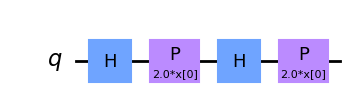

In [ ]:
#show how ZFeatureMap works for one qubit
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap

# Create a Pauli feature map
feature_dim = 1  # Number of features (and therefore, number of qubits)
feature_map = ZFeatureMap(feature_dimension=feature_dim)

# Decompose the feature map
decomposed_map = feature_map.decompose()


num_qubits = feature_map.num_qubits
print("Number of qubits:", num_qubits)
depth = feature_map.depth()
print("Depth of the circuit:", depth)

# Draw the decomposed map
decomposed_map.draw('mpl')

In [ ]:
#distance for AER
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.circuit.library import ZFeatureMap
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix, state_fidelity
from scipy.linalg import svdvals
import numpy as np

# Parameters for 7 qubits
parameters = [[1],[2],[3],[4],[5],[6],[7]]


# Trace distance function
def trace_distance(dm1, dm2):
    diff = dm1 - dm2
    singular_values = svdvals(diff.data)
    return 0.5 * np.sum(np.abs(singular_values))
def QHTC_Distance_AER(parameters):
    # Create a quantum circuit with 7 qubits
    qc = QuantumCircuit(7)
    # Apply ZFeatureMap for each qubit with corresponding parameters
    for i in range(7):
        zfm = ZFeatureMap(feature_dimension=1, reps=1)
        zfm_qc=zfm.bind_parameters(parameters[i])
        qc.append(zfm_qc, [i])
    # Transpile circuit for optimization
    qc = transpile(qc)

    # Let's see the state vector
    sv_sim = Aer.get_backend('statevector_simulator')
    job_sim = execute(qc, sv_sim)
    statevec = job_sim.result().get_statevector()

    # Compute the trace distance and fidelity for each pair of qubits
    dms = []
    for i in range(7):
        reduced_dm = partial_trace(Statevector(statevec), [j for j in range(7) if j != i])
        dms.append(DensityMatrix(reduced_dm.data))
        # Visualize the state on Bloch sphere
        #print(f"Bloch sphere for qubit {i}:")
        #display(plot_bloch_multivector(DensityMatrix(reduced_dm.data)))

    # Compute the trace distance for each adjacent pair of qubits and the pair of the last and the first qubit
    distances = []
    for i in range(6):
        trace_distance_value = trace_distance(dms[i], dms[i+1])
        #print(f"Trace distance between qubit {i} and {i+1}: {trace_distance_value}")
        distances.append(trace_distance_value)

    trace_distance_value = trace_distance(dms[6], dms[0])
    #print(f"Trace distance between qubit {6} and {0}: {trace_distance_value}")
    distances.append(trace_distance_value)
    return sum(distances)

print(f"QHTC Distance: {QHTC_Distance_AER(parameters)}")


QHTC Distance: 5.3282414070463044


In [ ]:
# To facilitate academic review, the associated dataset has been made freely accessible via the data container provided below.
!wget https://dgadata.blob.core.windows.net/dga/BotnetDgaDataset_5000_newMethod.csv

--2023-07-25 07:54:40--  https://dgadata.blob.core.windows.net/dga/BotnetDgaDataset_5000_newMethod.csv
Resolving dgadata.blob.core.windows.net (dgadata.blob.core.windows.net)... 20.60.2.68
Connecting to dgadata.blob.core.windows.net (dgadata.blob.core.windows.net)|20.60.2.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379327 (370K) [text/csv]
Saving to: ‘BotnetDgaDataset_5000_newMethod.csv’

BotnetDgaDataset_50 100%[===================>] 370.44K  --.-KB/s    in 0.09s   

2023-07-25 07:54:40 (3.82 MB/s) - ‘BotnetDgaDataset_5000_newMethod.csv’ saved [379327/379327]



In [ ]:
#Quantum enhanced HTC
from qiskit import execute, Aer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, StatePreparation
from qiskit import QuantumCircuit, transpile, assemble, Aer
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import Statevector, state_fidelity
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.quantum_info import Statevector, state_fidelity
import numpy as np
import warnings
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc
from sklearn import preprocessing
from qiskit_machine_learning.kernels import FidelityQuantumKernel, QuantumKernel

warnings.filterwarnings("ignore")

class HoeffdingTreeClassifier:
    def __init__(self, n_features, n_classes, delta=0.01, tie_threshold=0.05):
        self.n_features = n_features
        self.n_classes = n_classes
        self.delta = delta
        self.tie_threshold = tie_threshold

        # Initialize the root node of the tree
        self.root = TreeNode(self.delta)

    def predict(self, X):
        #Predict the class labels for the input instances X.
        y_pred = []
        for x in X:
            node = self.root
            while not node.is_leaf():
                if node.split_attr is None:
                    break
                feature_val = str(x[node.split_attr])
                if feature_val not in node.children:
                    break
                node = node.children[feature_val]
            y_pred.append(node.get_majority_class())
        return y_pred


    def partial_fit(self, X, y):
        #Update the tree with new training instances X and their corresponding class labels y
        n_samples = X.shape[0]
        for i in range(n_samples):
            x = X[i]
            label = y[i]
            self._update_statistics(x, label)
            self._attempt_split(self.root)



    def _update_statistics(self, x, label):
        #Update the statistics of the tree nodes based on the input instance and its class label
        node = self.root
        node.total_samples += 1

        if label not in node.class_counts:
            node.class_counts[label] = 0

        node.class_counts[label] += 1

        while node.is_split():
            attr = node.split_attr
            attr_val = str(x[attr])
            if attr_val not in node.children:
                node.children[attr_val] = TreeNode(self.delta)
            node = node.children[attr_val]
            node.total_samples += 1

            if label not in node.class_counts:
                node.class_counts[label] = 0

            node.class_counts[label] += 1


    def _attempt_split(self, node):
        #Attempt to split the given node based on the Hoeffding bound gain
        if not node.is_split():
            if node.total_samples >= 2:
                node.compute_error_rate()

            if node.total_samples >= 2 and node.error_rate > self._hoeffding_bound(node.total_samples):
                self._split_node(node)
        else:
            for child in node.children.values():
                self._attempt_split(child)

    def _split_node(self, node):
        #Split the given node by selecting the best attribute based on the Hoeffding bound gain
        node.compute_best_splitting_attribute(self.n_classes, self.n_features)

        for attr_val in node.children:
            child = node.children[attr_val]
            if child.total_samples >= 2:
                child.compute_error_rate()

            if child.total_samples < 2 or child.error_rate <= self._hoeffding_bound(child.total_samples):
                continue

            # Create a new leaf node for the child
            leaf_node = TreeNode(self.delta)
            leaf_node.label = child.get_majority_class()
            node.children[attr_val] = leaf_node

    def _hoeffding_bound(self, n):
        #Compute the Hoeffding bound for the given number of samples n
        return np.sqrt((self.n_classes * np.log(1 / self.delta)) / (2 * n))


class TreeNode:
    def __init__(self, delta):
        self.split_attr = None
        self.children = {}
        self.class_counts = {}
        self.total_samples = 0
        self.error_rate = 0.0
        self.label = None
        self.delta = delta

    def is_leaf(self):
        #Check if the node is a leaf (no children)
        return not self.children

    def is_split(self):
        #Check if the node is split (has children).
        return self.split_attr is not None

    def compute_error_rate(self):
        #Compute the error rate of the node based on the class distribution.
        total_samples = float(self.total_samples)
        error_sum = total_samples - max(self.class_counts.values())
        self.error_rate = error_sum / total_samples

    def compute_best_splitting_attribute(self, n_classes, n_features):
        #Compute the best attribute to split on based on the Hoeffding bound gain.
        best_gain = -np.inf
        best_attr = None

        for attr in range(n_features):
            class_counts_per_value = {}
            total_samples_per_value = {}

            for attr_val, child in self.children.items():
                class_counts_per_value[attr_val] = child.class_counts.get(attr_val, np.zeros(n_classes))
                total_samples_per_value[attr_val] = child.total_samples

            split_gain = self._compute_hoeffding_bound_gain(class_counts_per_value, total_samples_per_value,
                                                            n_classes, self.total_samples)

            if split_gain > best_gain:
                best_gain = split_gain
                best_attr = attr

        if best_attr is not None:
            self.split_attr = best_attr

    def _compute_hoeffding_bound_gain(self, class_counts_per_value, total_samples_per_value, n_classes, total_samples):
        #Compute the Hoeffding bound gain for the given attribute values and their class counts
        gain = 0.0

        for attr_val in class_counts_per_value:
            class_counts = class_counts_per_value[attr_val]
            total_samples_val = total_samples_per_value[attr_val]
            error_val = total_samples_val - np.max(class_counts)
            error_rate_val = error_val / total_samples_val

            gain -= total_samples_val / total_samples * self._hoeffding_bound(error_rate_val)

        return gain

    def _hoeffding_bound(self, error_rate):
        #Compute the Hoeffding bound for the given error rate
        R = 1  # Range of the target variable for binary classification
        return np.sqrt((R ** 2 * np.log(1 / self.delta)) / (2 * error_rate))

    def get_majority_class(self):
        #Get the majority class label based on the class distribution
        max_count = -np.inf
        majority_class = None

        for class_label, count in self.class_counts.items():
            if count > max_count:
                max_count = count
                majority_class = class_label

        return majority_class



def run_hoeffding_tree(data_encoding_fn, backend):
    # Load the dataset
    df = pd.read_csv('BotnetDgaDataset_5000_newMethod.csv', delimiter=',', encoding='utf-8-sig')
    data = df.to_numpy()
    # Extract the features and labels
    features = data[:, :-1]
    labels = data[:, -1]
    print("len(features)-1=",len(features)-1)
    # Normalize the features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    # Map the features to a quantum feature space using the provided data encoding function
    #feature_map_f = data_encoding_fn(feature_dimension=features.shape[1])

    jobcounter=0
    # Initialize lists to hold circuits and results for features and labels
    feature_results = []
    label_results = []
    feature_statevectors =[]
    label_statevectors =[]
    quantum_walksF = []

    # Iterate through both features and labels simultaneously
    for feature_row, label in zip(features, labels):
        jobcounter += 1
        feature_row_reshaped = feature_row.reshape(-1, 1)  # Fix here: use feature_row instead of data
        d=QHTC_Distance_AER(feature_row_reshaped)
        print(f'Job {jobcounter} of {len(features)} has successfully run')  # Print progress
        quantum_walksF.append(d)
    print(len(quantum_walksF),len(labels))
    # Combine the quantum walks and labels
    new_data = np.column_stack([quantum_walksF, labels])
    print(new_data)
    print("now QHTC")

    # Initialize the HoeffdingTreeClassifier
    n_features = new_data.shape[1] - 1
    n_classes = len(np.unique(labels))
    htc = HoeffdingTreeClassifier(n_features, n_classes)

    # Store accuracy, increment number, and additional metrics
    accuracies = []
    incrementes = []
    roc_auc_values = []
    precisions = []
    recalls = []
    f1_scores = []
    # Store fpr, tpr, and additional metrics for each increment
    fpr_values = []
    tpr_values = []
    # Set the desired test percentage
    test_percentage = 0.2

    # Calculate the increment size based on the test percentage
    #increment_size = int(len(quantum_features) * test_percentage)
    increment_size=1000
    # Iterate over the data in incrementes
    for i in range(0, len(new_data), increment_size):
        # Split the increment into training and testing sets
        X_train = np.concatenate([new_data[:i, :-1], new_data[i+increment_size:, :-1]])
        y_train = np.concatenate([new_data[:i, -1], new_data[i+increment_size:, -1]])
        y_train = np.where(y_train == 3.0, 1.0, y_train)
        X_test = new_data[i:i+increment_size, :-1]
        y_test = new_data[i:i+increment_size, -1]
        y_test = np.where(y_test == 3.0, 1.0, y_test)

        # Train the HoeffdingTreeClassifier with the increment data
        htc.partial_fit(X_train, y_train)

        # Calculate accuracy on the test data
        test_predictions = htc.predict(X_test)
        test_accuracy = np.mean(test_predictions == y_test)

        # Calculate additional performance metrics

        fpr, tpr, _ = roc_curve(y_test, test_predictions)

        # Store fpr and tpr for the current increment
        fpr_values.append(fpr)
        tpr_values.append(tpr)

        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, test_predictions)
        f1 = f1_score(y_test, test_predictions)

        # Store accuracy, increment number, and additional metrics
        accuracies.append(test_accuracy)
        incrementes.append(i+increment_size)
        roc_auc_values.append(roc_auc)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Print or store the accuracy and additional metrics as desired
        print(f"Accuracy for increment {i//increment_size + 1}: {test_accuracy}")
        print(f"AUC for increment {i//increment_size + 1}: {roc_auc}")
        print(f"F1-score for increment {i//increment_size + 1}: {f1}")

    # Get the name of the data encoding function
    encoding_name = data_encoding_fn.__name__

    # Plot accuracy vs. increment
    plt.plot(incrementes, accuracies)
    plt.xlabel('increment Size')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. increment Size ({encoding_name})')
    plt.show()

    # Plot ROC curves
    plt.figure()
    for i in range(len(fpr_values)):
        if i < len(roc_auc_values):  # Check if roc_auc_values has enough values
            roc_auc = roc_auc_values[i]
            label = f'increment {i+1} (AUC = {roc_auc:.2f})'
        else:
            label = f'increment {i+1}'
        plt.plot(fpr_values[i], tpr_values[i], label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({encoding_name})')
    plt.legend(loc='lower right')
    plt.show()

    # Plot precision-recall curves
    plt.figure()
    for i in range(len(incrementes)):
        plt.plot(recalls[i], precisions[i], label=f'increment {i+1}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves ({encoding_name})')
    plt.legend(loc='lower right')
    plt.show()

    # Plot F1-score vs. increment
    plt.plot(incrementes, f1_scores)
    plt.xlabel('increment Size')
    plt.ylabel('F1-score')
    plt.title(f'F1-score vs. increment Size ({encoding_name})')
    plt.show()



Streaming output truncated to the last 5000 lines.
Job 29 of 5001 has successfully run
Job 30 of 5001 has successfully run
Job 31 of 5001 has successfully run
Job 32 of 5001 has successfully run
Job 33 of 5001 has successfully run
Job 34 of 5001 has successfully run
Job 35 of 5001 has successfully run
Job 36 of 5001 has successfully run
Job 37 of 5001 has successfully run
Job 38 of 5001 has successfully run
Job 39 of 5001 has successfully run
Job 40 of 5001 has successfully run
Job 41 of 5001 has successfully run
Job 42 of 5001 has successfully run
Job 43 of 5001 has successfully run
Job 44 of 5001 has successfully run
Job 45 of 5001 has successfully run
Job 46 of 5001 has successfully run
Job 47 of 5001 has successfully run
Job 48 of 5001 has successfully run
Job 49 of 5001 has successfully run
Job 50 of 5001 has successfully run
Job 51 of 5001 has successfully run
Job 52 of 5001 has successfully run
Job 53 of 5001 has successfully run
Job 54 of 5001 has successfully run
Job 55 of 500

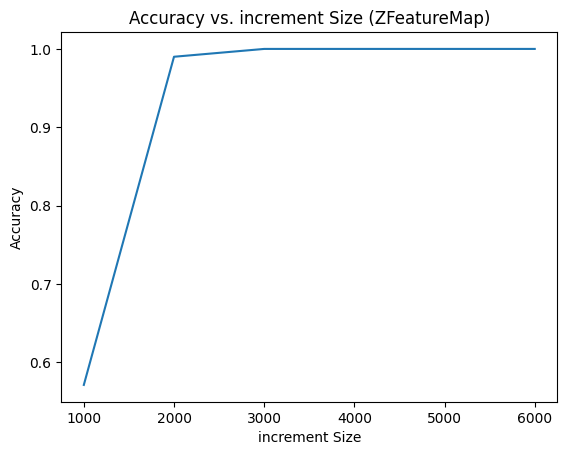

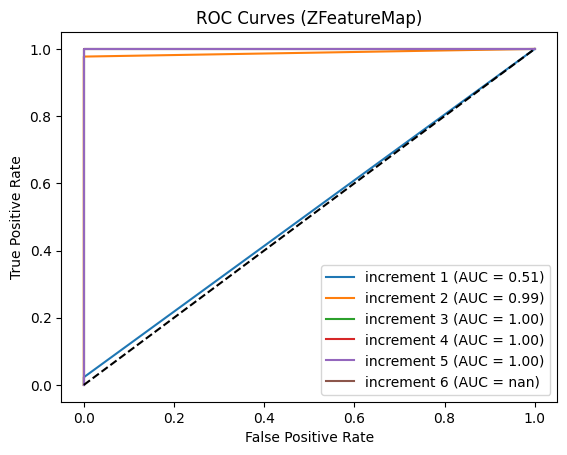

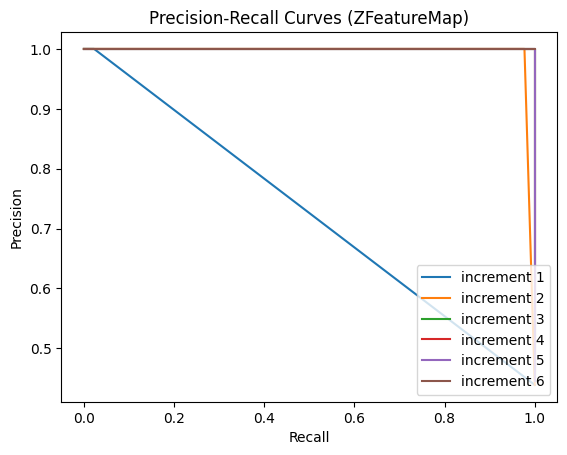

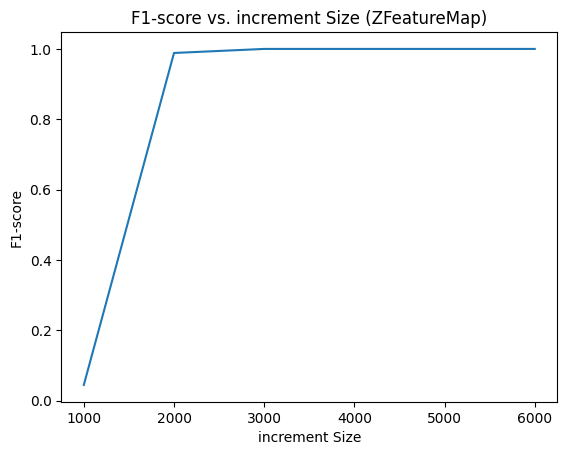

time of round= 1 655.346736641


In [ ]:
Active_Backend = aer_simulator = Aer.get_backend('statevector_simulator')

# Define a list of data encoding functions
#data_encoding_functions = [ZFeatureMap, ZZFeatureMap, PauliFeatureMap]
data_encoding_functions = [ZFeatureMap]

start=start = time.perf_counter()
round=0
# Run the Hoeffding Tree algorithm for each data encoding function
for data_encoding_fn in data_encoding_functions:
    start=start = time.perf_counter()
    run_hoeffding_tree(data_encoding_fn, Active_Backend)
    #run_hoeffding_tree(data_encoding_fn)
    end = time.perf_counter()
    round=round+1
    print("time of round=",round, end-start)
